# Pytorch Sandbox

## Environment Setup


In [1]:
# Installing libraries
!pip install torchinfo

In [2]:
# General libraries
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os

# Pytorch Model and training necessities
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchinfo import summary # For model architecture summary

# Model performance evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

# Pytorch tensorboard support
from torch.utils.tensorboard import SummaryWriter

2024-04-02 17:48:02.544578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 17:48:02.544681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 17:48:02.680476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Experiments

In [5]:
# Create some synthetic data
x = torch.tensor([1.0, 2.0, 3.0, 4.0], requires_grad=True)  # Input feature
y_true = torch.tensor([2.0, 4.0, 6.0, 8.0])  # True target values

# Define model parameters (weights and bias)
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

# Forward pass
y_pred = w * x + b

# Calculate loss (Mean Squared Error)
loss = torch.mean((y_pred - y_true)**2)

# Backward pass (Autograd computes gradients automatically)
loss.backward()

# Gradients are computed
print("Gradient of w:", w.grad)
print("Gradient of b:", b.grad)

Gradient of w: tensor(-15.)
Gradient of b: tensor(-5.)


## Full model development flow example (FashionMNIST)

In [3]:
# Checking the availability of GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Define the CNN architecture
class FashionCNN(nn.Module):
    def __init__(self):
        # Calling nn.Module init method
        super(FashionCNN, self).__init__() # Similar to super().___init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=1)
        # The input shape of the linear layer below correspond to the number of pixels
        # after the input has been flattened, which is output channel of previous channel * height * width.
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(-1, 16*5*5) # Equivalent to flat layers (Reshape tensor). -1 let pytorch infer the second dimension
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [5]:
# Initialize the model, loss function, and optimizer
model = FashionCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionCNN                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 26, 26]            156
├─ReLU: 1-2                              [1, 6, 26, 26]            --
├─MaxPool2d: 1-3                         [1, 6, 13, 13]            --
├─Conv2d: 1-4                            [1, 16, 11, 11]           2,416
├─ReLU: 1-5                              [1, 16, 11, 11]           --
├─MaxPool2d: 1-6                         [1, 16, 5, 5]             --
├─Linear: 1-7                            [1, 128]                  51,328
├─ReLU: 1-8                              [1, 128]                  --
├─Linear: 1-9                            [1, 84]                   10,836
├─ReLU: 1-10                             [1, 84]                   --
├─Linear: 1-11                           [1, 10]                   850
Total params: 65,586
Trainable params: 65,586
Non-trainable params: 0
To

In [7]:
# Inspecting the first fully connected layer of the model
fc1_weights = model.fc1.weight
print(fc1_weights)

Parameter containing:
tensor([[-0.0494, -0.0297, -0.0040,  ...,  0.0356, -0.0077, -0.0308],
        [-0.0071, -0.0481,  0.0284,  ...,  0.0481,  0.0322,  0.0346],
        [ 0.0097,  0.0327,  0.0022,  ..., -0.0499, -0.0491,  0.0098],
        ...,
        [ 0.0453,  0.0357, -0.0247,  ...,  0.0432, -0.0361,  0.0360],
        [ 0.0254, -0.0240,  0.0361,  ...,  0.0056,  0.0024,  0.0409],
        [ 0.0272,  0.0016, -0.0474,  ...,  0.0468,  0.0381,  0.0329]],
       device='cuda:0', requires_grad=True)


As we can see, by default, all tensors used for storing model's parameters have their `requires_grad` property set to true. Without `requires_grad` property set to true, we won't able to find its gradient with Autograd during back propagation.

In [8]:
# Getting the number of weights of the first fully connected layer
len(fc1_weights[0])

400

Here, the number of weights of the 1st fully connected layer is 400 weights. This is derived from the dimensions of the output of the previous convolutional layer (16, 5, 5) that has been flattenned into 1d vector (16 * 5 * 5 = 400).

In [4]:
# Transformations to be applied to each image
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion-MNIST dataset
root = os.path.join(os.getcwd(),"FMNIST")
train_dataset = datasets.FashionMNIST(
    root=root, 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transform
)

100%|██████████| 26421880/26421880 [00:01<00:00, 18201401.17it/s]


Extracting /kaggle/working/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269438.54it/s]


Extracting /kaggle/working/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/FMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5096781.12it/s]


Extracting /kaggle/working/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7499922.54it/s]

Extracting /kaggle/working/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/FMNIST/FashionMNIST/raw



In [38]:
# Inspecting the type of dataset
type(train_dataset)

torchvision.datasets.mnist.FashionMNIST

In [5]:
# Create data loaders (Iterable) to load dataset in batches (List of Tensors).
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=4, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=4, 
    shuffle=False
)

# Class labels
classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot'
)

# Display split sizes
print("Training size: {}".format(len(train_dataset)))
print("Validation size: {}".format(len(test_dataset)))

Training size: 60000
Validation size: 10000


In [37]:
# Inspecting the type of data loader
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [6]:
# Getting & displaying the first batch of data
# 1st element of the list -> A single batch of images (4 Images).
# 2nd element of the list -> A list containing corresponding labels for each image.
x = iter(train_loader)
sample = next(x)
sample

[tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -0.9843, -1.0000, -1.0000],
           [-1.0000, -1.0000, -0.8902,  ..., -0.7647, -1.0000, -1.0000],
           [-1.0000, -1.0000, -0.5216,  ..., -0.4980, -1.0000, -1.0000],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9843, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],
 
 
         [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],
 
 
         [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
       

In [13]:
# Getting an individual image from the batch
temp = sample[0][0]
print(temp.shape)
temp

torch.Size([1, 28, 28])


tensor([[[-1.0000, -1.0000, -1.0000, -0.4980, -0.5216, -0.5529, -0.4824,
          -0.5529, -0.4980, -0.6863, -0.6706, -0.7255, -0.7647, -0.7647,
          -0.8196, -0.7255, -0.6863, -0.6078, -0.6471, -0.6863, -0.7020,
          -0.5765, -0.5373, -0.5373, -0.5216, -0.9843, -1.0000, -1.0000],
         [-1.0000, -1.0000, -0.8902, -0.4431, -0.4980, -0.5216, -0.3098,
          -0.5216, -0.4431, -0.4275, -0.3882, -0.4588, -0.5373, -0.5765,
          -0.4431, -0.3098, -0.6078, -0.5922, -0.3647, -0.4039, -0.5765,
          -0.4980, -0.5216, -0.6314, -0.4431, -0.7647, -1.0000, -1.0000],
         [-1.0000, -1.0000, -0.5216, -0.5373, -0.5529, -0.4275, -0.0902,
          -0.4275, -0.3882, -0.3882, -0.4275, -0.6078, -0.6314, -0.6314,
          -0.4588, -0.3490, -0.6706, -0.5922, -0.5765, -0.4275, -0.6314,
          -0.3882, -0.2549, -0.7020, -0.4824, -0.4980, -1.0000, -1.0000],
         [-1.0000, -0.9843, -0.4039, -0.5529, -0.5765, -0.1843,  0.2706,
          -0.3098, -0.3333, -0.3647, -0.5216, -0

In [16]:
# Checking the requires_grad attribute of input tensor
temp.requires_grad

False

**REMEMBER! WE DON'T COMPUTE GRADIENTS FOR INPUT DATA BUT FOR MODEL PARAMETERS (Weights & Biases)**

Image shape:  torch.Size([4, 1, 28, 28])
Ankle Boot Coat Sneaker Sneaker


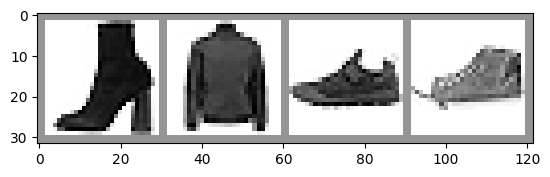

In [17]:
# Sanity check (Visualizing the first batch of images & labels)
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1,2,0)))

# The dataloader implement the iter protocol (iter magic method),
# thus to access data within it (batches of image & label)
# we must create an iterator object from it.
dataiter = iter(train_loader)
# Getting the first batch of images & labels (32 pairs)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('Image shape: ', images.shape)
print(' '.join(classes[labels[j]] for j in range(len(labels))))

In [19]:
# Training function
def train_one_epoch(epoch_index, tb_writer):
  running_loss = 0.
  last_loss = 0.

  # Looping each batch of data
  for i, (inputs, labels) in enumerate(train_loader):
    # Every data instance is a batch of image & label pairs.
    inputs, labels = inputs.to(device), labels.to(device)
    # Setting the gradient to zero for every batch (Mini-batch gradient descent)
    optimizer.zero_grad()
    # Compute the predictions for this batch (The forward method is called implicitly)
    outputs = model(inputs)
    # Compute the loss 
    loss = loss_fn(outputs, labels)
    # Compute the gradients using autograd
    loss.backward()
    # Adjusting the learning weights (Backprop)
    optimizer.step()
    # Logging the loss for each 1k batches.
    # For the current config (4 batches), there will be 15k batches in 1 epoch.
    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000
      print(f'Batch {i+1} loss: {last_loss}')
      # Visualizing with tensorboard
      tb_x = epoch_index * len(train_loader) + i + 1
      tb_writer.add_scalar('Loss/train', last_loss, tb_x)
      running_loss = 0.

  return last_loss

In [20]:
# Training loop
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0
EPOCHS = 5
best_vloss = 1_000_000. # vloss -> validation loss
for epoch in range(EPOCHS):
  print('\nEPOCH {}:'.format(epoch_number + 1))
  # Set the model to training mode
  model.train(True)
  # Calling the training function
  avg_loss = train_one_epoch(epoch_number, writer)
  running_vloss = 0.0
  # Set the model to evaluation mode
  model.eval()
  # Temporarily disable gradient computation during inference for validation data.
  with torch.no_grad():
    for i, (vinputs, vlabels) in enumerate(test_loader):
      vinputs, vlabels = vinputs.to(device), vlabels.to(device)
      voutputs = model(vinputs)
      vloss = loss_fn(voutputs, vlabels)
      running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('Training loss: {}, validation loss: {}'.format(avg_loss, avg_vloss))

  # Log the average running loss per batch for training & validation
  writer.add_scalars(
      'Training vs. Validation Loss',
      {'Training': avg_loss, 'Validation': avg_vloss},
      epoch_number + 1
  )
  writer.flush()

  # Track best performance, and save the model's sate
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_path)

  epoch_number += 1


EPOCH 1:
Batch 1000 loss: 1.9121681880652905
Batch 2000 loss: 0.8608711149208248
Batch 3000 loss: 0.6797803851682693
Batch 4000 loss: 0.6117923960955813
Batch 5000 loss: 0.5623956329380162
Batch 6000 loss: 0.5267888390785083
Batch 7000 loss: 0.5129248777227476
Batch 8000 loss: 0.4892858238525223
Batch 9000 loss: 0.46392954911629203
Batch 10000 loss: 0.4460567360999412
Batch 11000 loss: 0.40707099902589106
Batch 12000 loss: 0.4167586170655559
Batch 13000 loss: 0.38594459228112826
Batch 14000 loss: 0.40500220755289773
Batch 15000 loss: 0.391686304132214
Training loss: 0.391686304132214, validation loss: 0.4003625214099884

EPOCH 2:
Batch 1000 loss: 0.3785476180012047
Batch 2000 loss: 0.3685678926896362
Batch 3000 loss: 0.35906948553479745
Batch 4000 loss: 0.3564164625175326
Batch 5000 loss: 0.33903039502090543
Batch 6000 loss: 0.3526441483788658
Batch 7000 loss: 0.3632479494495492
Batch 8000 loss: 0.3118566998069218
Batch 9000 loss: 0.3406563904377981
Batch 10000 loss: 0.348473921053810

In [6]:
# Load pre-trained weights
model.load_state_dict(torch.load('/kaggle/input/variant_1/pytorch/test-1/1/model_20240325_185715_2'))

<All keys matched successfully>

In [ ]:
test_loader

In [15]:
# Calculating multiclassification metrics & confusion matrix
model.eval()
with torch.no_grad():
    for vinputs, vlabels in test_loader:
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        # Sending back the outputs & label to CPU
        voutputs = voutputs.detach().cpu().numpy()
        vlabels = vlabels.detach().cpu().numpy()
    
precision = precision_score(vlabels, voutputs.argmax(axis=1), average='macro')
recall = recall_score(vlabels, voutputs.argmax(axis=1), average='macro')
f1 = f1_score(vlabels, voutputs.argmax(axis=1), average='macro')

print('Precission: ', precision)
print('Recall: ', recall)
print('F1_Macro: ', f1)

Precission:  1.0
Recall:  1.0
F1_Macro:  1.0


In [17]:
voutputs.argmax(axis=1)

array([1, 8, 1, 5])

In [18]:
vlabels

array([1, 8, 1, 5])

Calculate accuracy too, or matrix for better.

In [22]:
# Final save for model & weights
torch.save(model, 'model.pth')

## Multimodal Model Experiment